In [174]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.0.0")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.0.0, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [175]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import os
import networkx as nx
import numpy as np
import pandas as pd
from stellargraph import datasets
from IPython.display import display, HTML

%matplotlib inline

In [176]:
# dataset = datasets.Cora()
# display(HTML(dataset.description))
# G, node_subjects = dataset.load(largest_connected_component_only=True)

In [177]:
FILE_NAME = 'GM12878_tf2tf.csv'
SEP = ','

df = pd.read_csv('../data/'+FILE_NAME, sep=SEP)[['source', 'target', 'weight']]
df.duplicated(subset=None, keep='first').value_counts()

False    2183
True       13
dtype: int64

In [178]:
nx_graph = nx.from_pandas_edgelist(df[['source', 'target', 'weight']], 'source', 'target', edge_attr='weight', create_using=nx.DiGraph)
print(nx.info(nx_graph))

Name: 
Type: DiGraph
Number of nodes: 69
Number of edges: 2183
Average in degree:  31.6377
Average out degree:  31.6377


In [179]:
G = sg.StellarDiGraph(edges=df)

print(G.info())

StellarDiGraph: Directed multigraph
 Nodes: 69, Edges: 2196

 Node types:
  default: [69]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [2196]
        Weights: range=[23.9614, 3105.97], mean=671.01, std=536.945


## Corpus generation using random walks

The stellargraph library provides an implementation for 2nd order random walks as required by Node2Vec. The random walks have fixed maximum length and are controlled by two parameters `p` and `q`. See [[1]](#refs) for a detailed description of these parameters. 

We are going to start 10 random walks from each node in the graph with a length up to 100. We set parameter `p` to 0.5 (which encourages backward steps) and `q` to 2.0 (which discourages distant steps); the net result is that walks should remain in the local vicinity of the starting nodes.

**`p`: return hyperparameter - smaller `p` encourages backward steps**

**`q`: inout hyperparameter - smaller `q` encourages distant steps**

In [180]:
from stellargraph.data import BiasedRandomWalk

rw = BiasedRandomWalk(G)

walks = rw.run(
    nodes=list(G.nodes()), # root nodes
    length=2,
    n=400,  # Number of random walks
    p=6,    # Defines (unormalised) probability, 1/p, of returning to source node
    q=1    # Defines (unormalised) probability, 1/q, for moving away from source node
)

# print(type(walks))

In [181]:
print(f'Number of random walks: {len(walks)}')
print(f'Sample of random walk list: {walks[1]}')

Number of random walks: 27600
Sample of random walk list: ['ATF3', 'CBX5']


In [182]:
from gensim.models import Word2Vec

str_walks = [[str(n) for n in walk] for walk in walks]
model = Word2Vec(str_walks, size=32, window=5, min_count=0, sg=1, workers=2, iter=1)

In [183]:
# The embedding vectors can be retrieved from model.wv using the node ID.
model.wv["ATF3"]

array([ 0.01957723, -0.00299091, -0.02260027, -0.00989922, -0.00358159,
        0.00499207, -0.00705621,  0.02499304,  0.02098593, -0.00568741,
        0.00088817,  0.0202311 , -0.01135623,  0.00743078, -0.00446945,
        0.01908704, -0.01451245,  0.01048738, -0.00373261,  0.0044131 ,
       -0.0213985 ,  0.01248954, -0.02710127, -0.00121065, -0.0206941 ,
        0.01521007, -0.00312718,  0.00391428, -0.01682188, -0.01309302,
       -0.012813  , -0.01637041], dtype=float32)

## Visualise Node Embeddings

We retrieve the Word2Vec node embeddings that are 128-dimensional vectors and then we project them down to 2 dimensions using the [t-SNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) algorithm.

In [184]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = (
    model.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality
# node_targets = node_subjects.loc[[int(node_id) for node_id in node_ids]]

In [185]:
transform = TSNE

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(node_embeddings)

In [186]:
# node_embeddings_2d[:, 0]
# node_ids

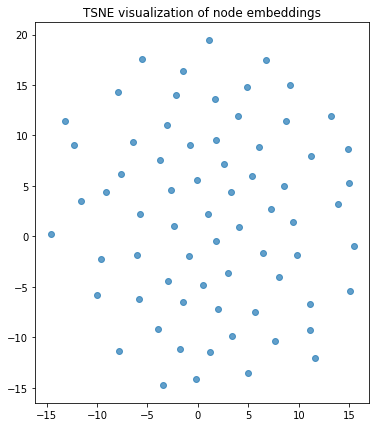

In [187]:
# draw the embedding points, coloring them by the target label (paper subject)
alpha = 0.7
# label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
# node_colours = [label_map[target] for target in node_targets]

plt.figure(figsize=(7, 7))
plt.axes().set(aspect="equal")
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
#     c=node_colours,
    cmap="jet",
    alpha=alpha,
)

# for i, txt in enumerate(node_ids):
#     plt.text( node_embeddings_2d[:, 0][i]+.03,  node_embeddings_2d[:, 1][i]+.03, txt, fontsize=9)
plt.title("{} visualization of node embeddings".format(transform.__name__))
plt.show()